# Cluster analysis

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler

### Load data

In [2]:
import glob
import pandas as pd

pre_path = 'data/'
suffix = '_clustered.csv'

# Get only CSV files from the data folder, excluding subfolders
subreddits = list(glob.glob('data/*.csv'))
subreddits = list(set([sub.split('\\')[1].split('_')[0] for sub in subreddits]))

n_subs = len(subreddits)

dfs_clustered = {}
for sub in subreddits:
    dfs_clustered[sub] = pd.read_csv(pre_path + sub + suffix, index_col='comment_id')

### Plotting comment distribution of clusters

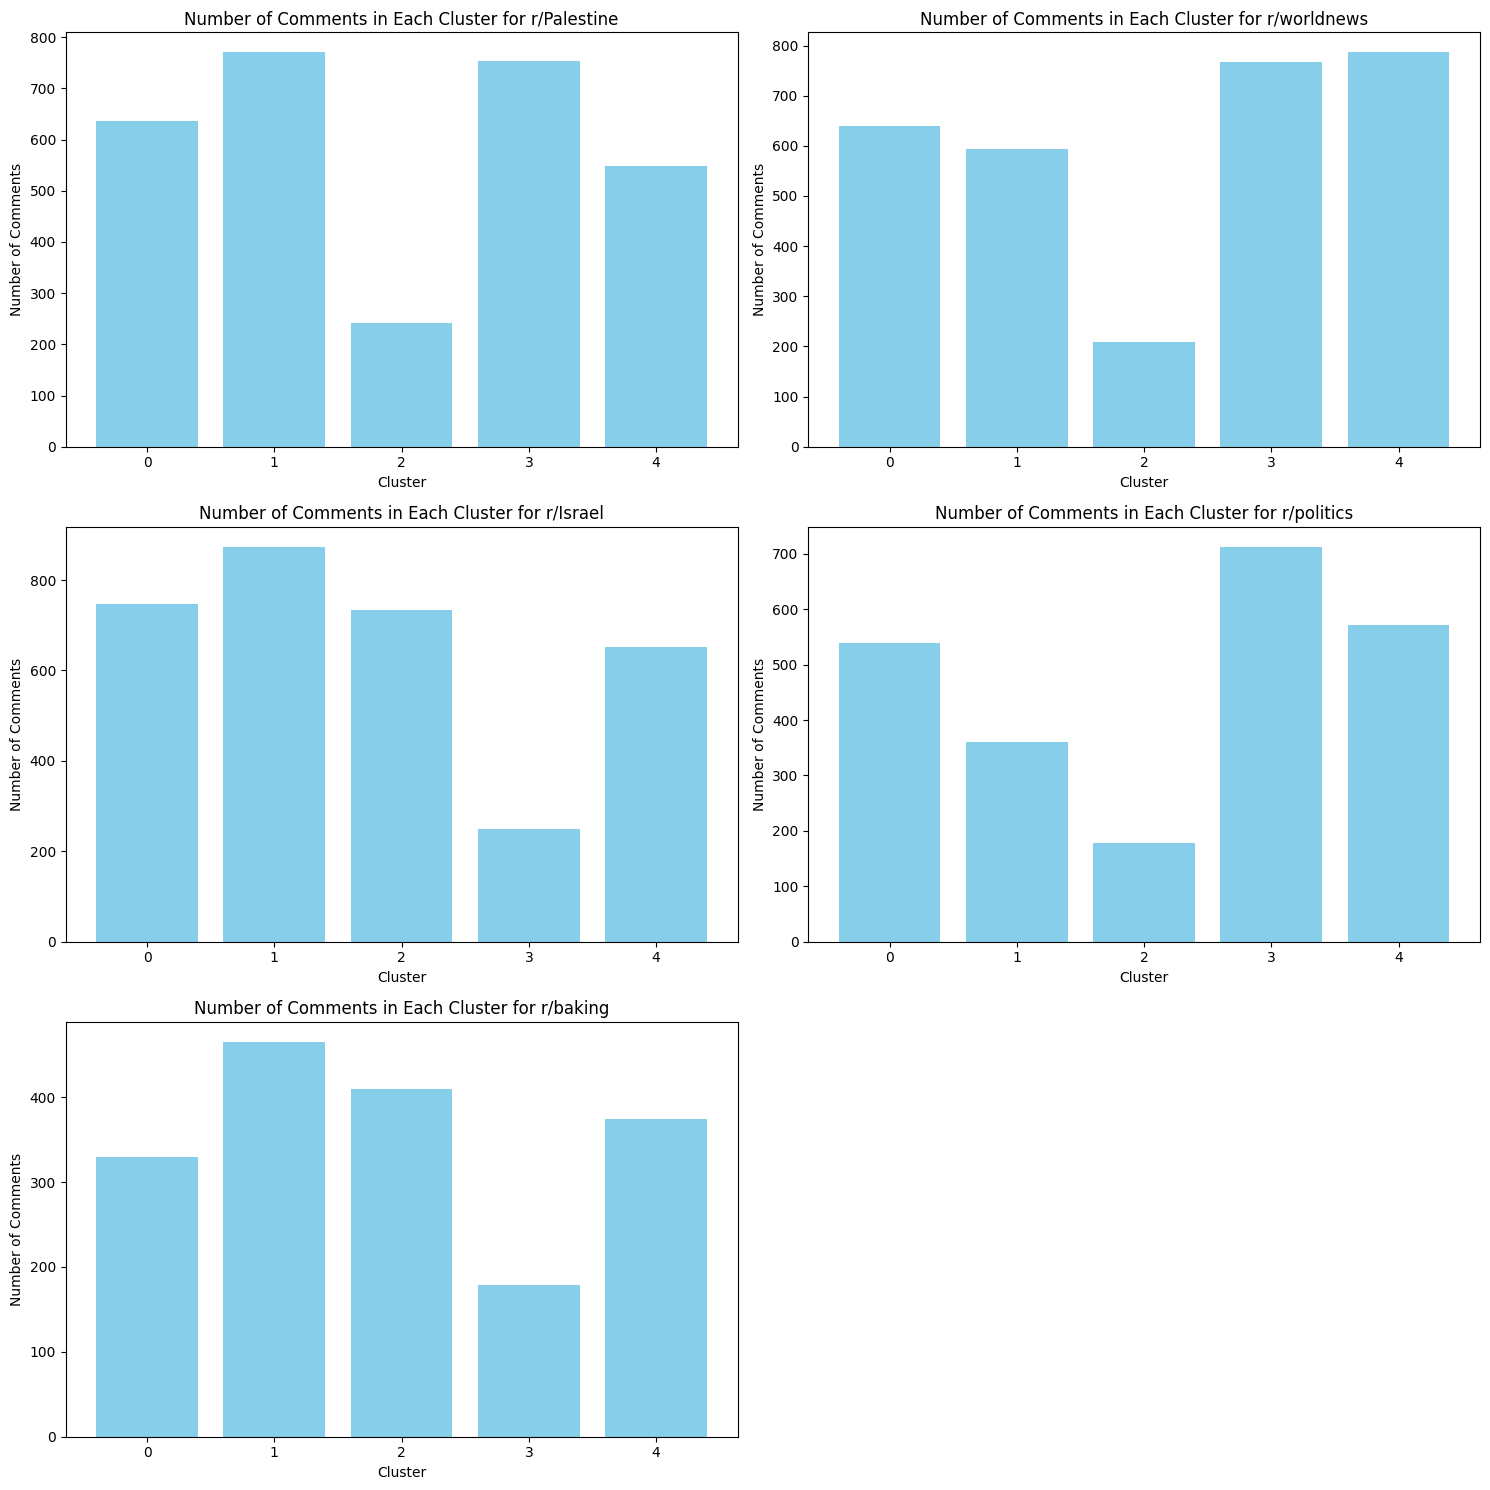

In [3]:
def plot_cluster_counts(dfs, cluster_column):
    """
    Plots the number of comments in each cluster for each subreddit.
    
    Parameters:
    - dfs: Dictionary of DataFrames containing the data for each subreddit.
    - cluster_column: Column with cluster labels.
    
    Returns:
    - None
    """
    n_subs = len(dfs)
    n_cols = 2
    n_rows = (n_subs + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten()
    
    for i, (sub, df) in enumerate(dfs.items()):
        # Count the number of comments in each cluster
        cluster_counts = df[cluster_column].value_counts().sort_index()
        
        # Plot the number of comments in each cluster
        axes[i].bar(cluster_counts.index, cluster_counts.values, color='skyblue')
        axes[i].set_title(f'Number of Comments in Each Cluster for r/{sub}')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel('Number of Comments')
        axes[i].set_xticks(cluster_counts.index)
        axes[i].set_xticklabels(cluster_counts.index, rotation=0)
    
    # Hide any unused subplot axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_cluster_counts(dfs_clustered, 'kmeans_cluster')

### Plotting the clusters in 3D

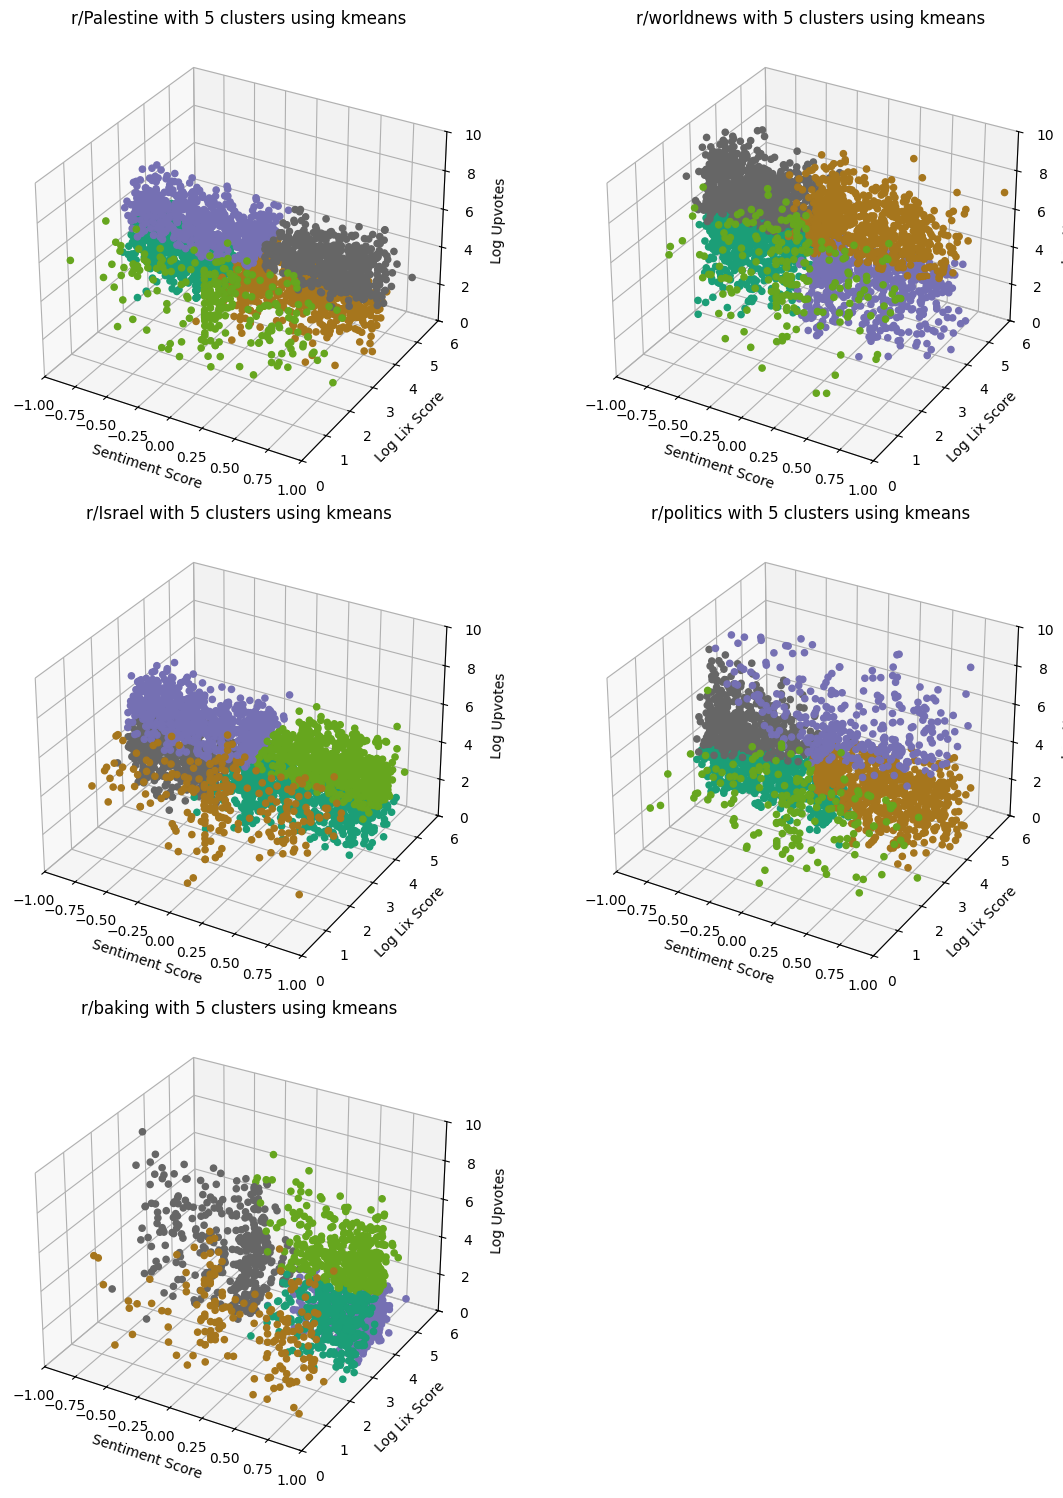

In [4]:
# Set clustering method for visualization
method = 'kmeans'
cluster_type = f'{method}_cluster'

# Calculate the number of rows and columns
n_cols = 2
n_subs = len(dfs_clustered)
n_rows = (n_subs + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 5), subplot_kw={'projection': '3d'})

log_lix_lim = [0, 6]  # Range for Lix Score
sentiment_lim = [-1, 1]  # Range for Sentiment Score
log_upvotes_lim = [0, 10]  # Range for Log Upvotes

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, (sub, df) in enumerate(dfs_clustered.items()):
    n_clusters = df[cluster_type].nunique()

    # Set color: grey for cluster -1, others will use a colormap
    colors = df[cluster_type].apply(lambda x: 'grey' if x == -1 else None)
    
    # Assign transparency: 50% for cluster -1, 100% (1.0) for others
    alphas = df[cluster_type].apply(lambda x: 0.1 if x == -1 else 1.0)

    # Handle valid colors for other clusters
    # Replace 'None' with colormap values for non -1 clusters
    cmap = plt.get_cmap('Dark2', n_clusters)
    cluster_colors = df[cluster_type].apply(lambda x: cmap(x) if x != -1 else 'grey')

    # Plot the 3D scatterplot
    scatter = axes[i].scatter(
        df['sentiment_score'], df['log_lix_score'], df['log_upvotes'],
        facecolors=cluster_colors, alpha=alphas
    )
    axes[i].set_title(f'r/{sub} with {n_clusters} clusters using {method}')
    axes[i].set_xlabel('Sentiment Score')
    axes[i].set_ylabel('Log Lix Score')
    axes[i].set_zlabel('Log Upvotes')
    # Set axis limits
    axes[i].set_xlim(sentiment_lim)
    axes[i].set_ylim(log_lix_lim)
    axes[i].set_zlim(log_upvotes_lim)

# Hide any unused subplot axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Plot clusters in 2D

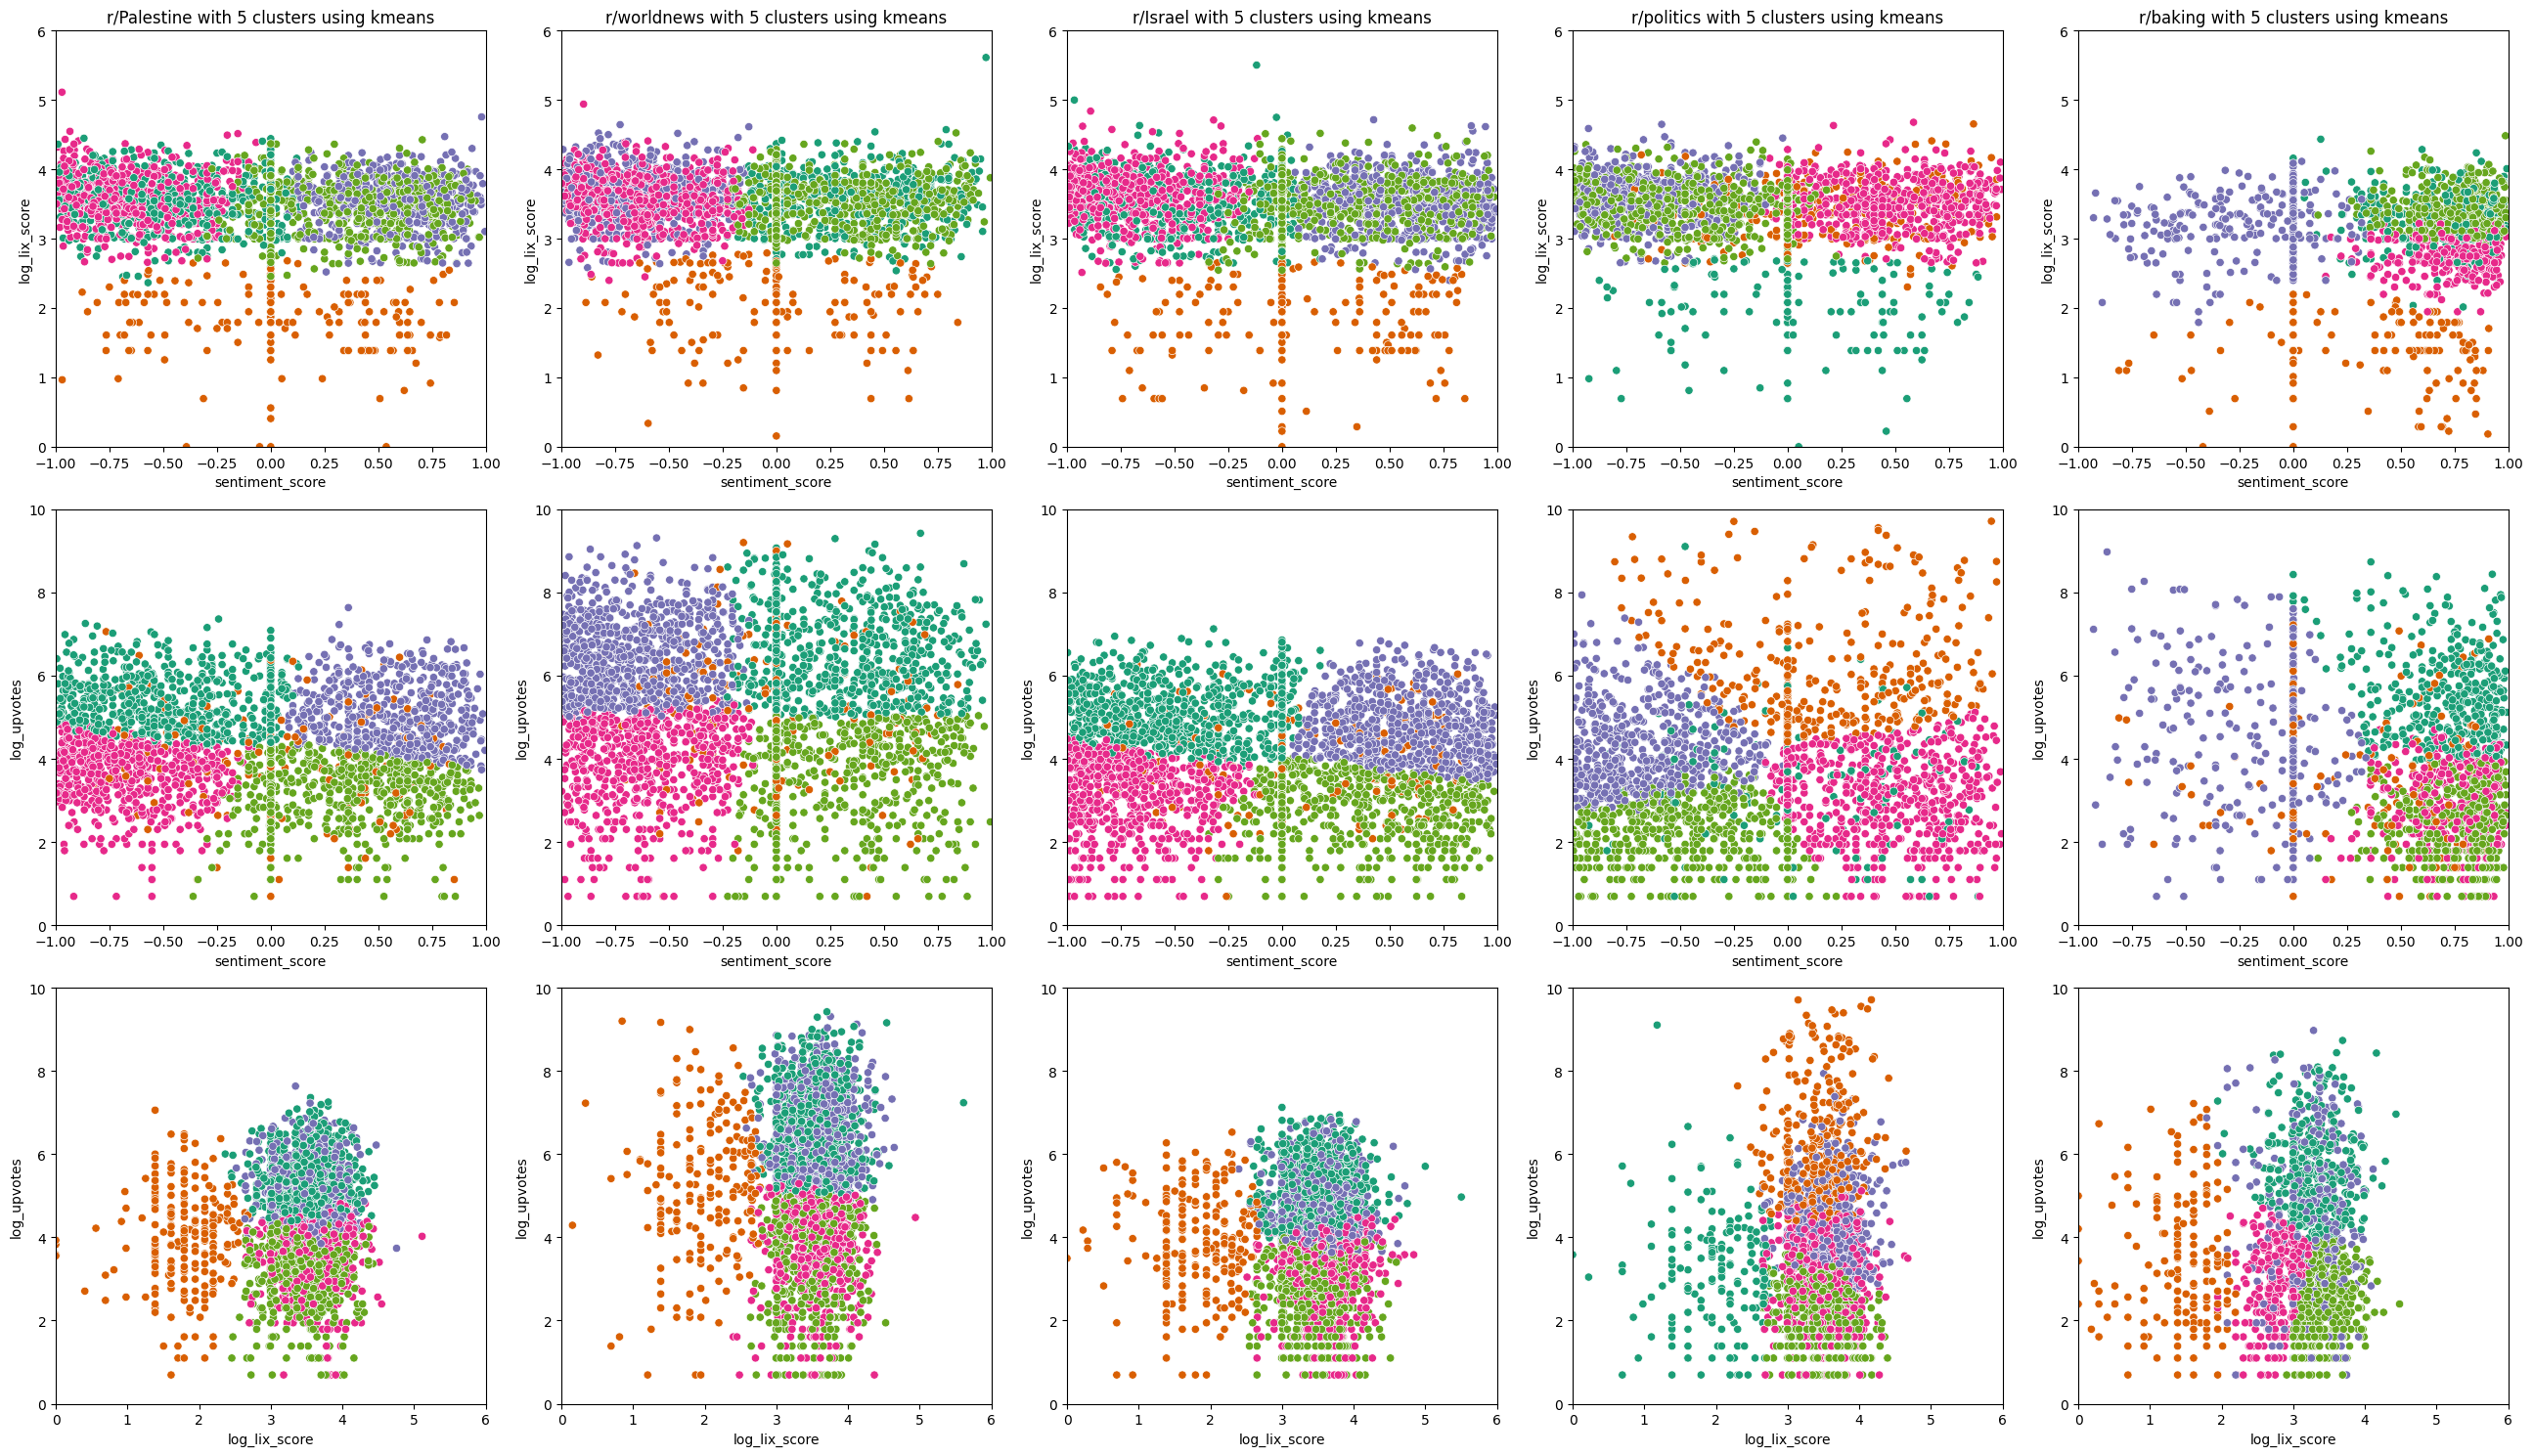

In [5]:
# Set clustering method for visualization
method = 'kmeans'
cluster_type = f'{method}_cluster'

fig, axes = plt.subplots(nrows=3, ncols=n_subs, figsize=(26, 15))

lix_lim = [0, 6]
sentiment_lim = [-1, 1]
log_upvotes_lim = [0, 10]

for i, (sub, df) in enumerate(dfs_clustered.items()):
    n_clusters = df[cluster_type].nunique()

    # Set color: grey for cluster -1, others will use a colormap
    colors = df[cluster_type].apply(lambda x: 'grey' if x == -1 else None)
    alphas = df[cluster_type].apply(lambda x: 0.1 if x == -1 else 1.0)
    
    # Handle valid colors for other clusters
    cmap = plt.get_cmap('Dark2', n_clusters)
    cluster_colors = df[cluster_type].apply(lambda x: cmap(x) if x != -1 else 'grey')

    # Plot the 2D scatterplots
    sns.scatterplot(ax=axes[0, i], data=df, x="sentiment_score", y="log_lix_score", hue=cluster_colors, palette='Dark2', legend=False, alpha=alphas)
    sns.scatterplot(ax=axes[1, i], data=df, x="sentiment_score", y="log_upvotes", hue=cluster_colors, palette='Dark2', legend=False, alpha=alphas)
    sns.scatterplot(ax=axes[2, i], data=df, x="log_lix_score", y="log_upvotes", hue=cluster_colors, palette='Dark2', legend=False, alpha=alphas)

    # Set axes limits
    axes[0, i].set_ylim(lix_lim)
    axes[0, i].set_xlim(sentiment_lim)
    axes[1, i].set_xlim(sentiment_lim)
    axes[1, i].set_ylim(log_upvotes_lim)
    axes[2, i].set_xlim(lix_lim)
    axes[2, i].set_ylim(log_upvotes_lim)

    axes[0, i].set_title(f'r/{sub} with {n_clusters} clusters using kmeans')

plt.tight_layout()
plt.show()


### Plotting the average values in 3D

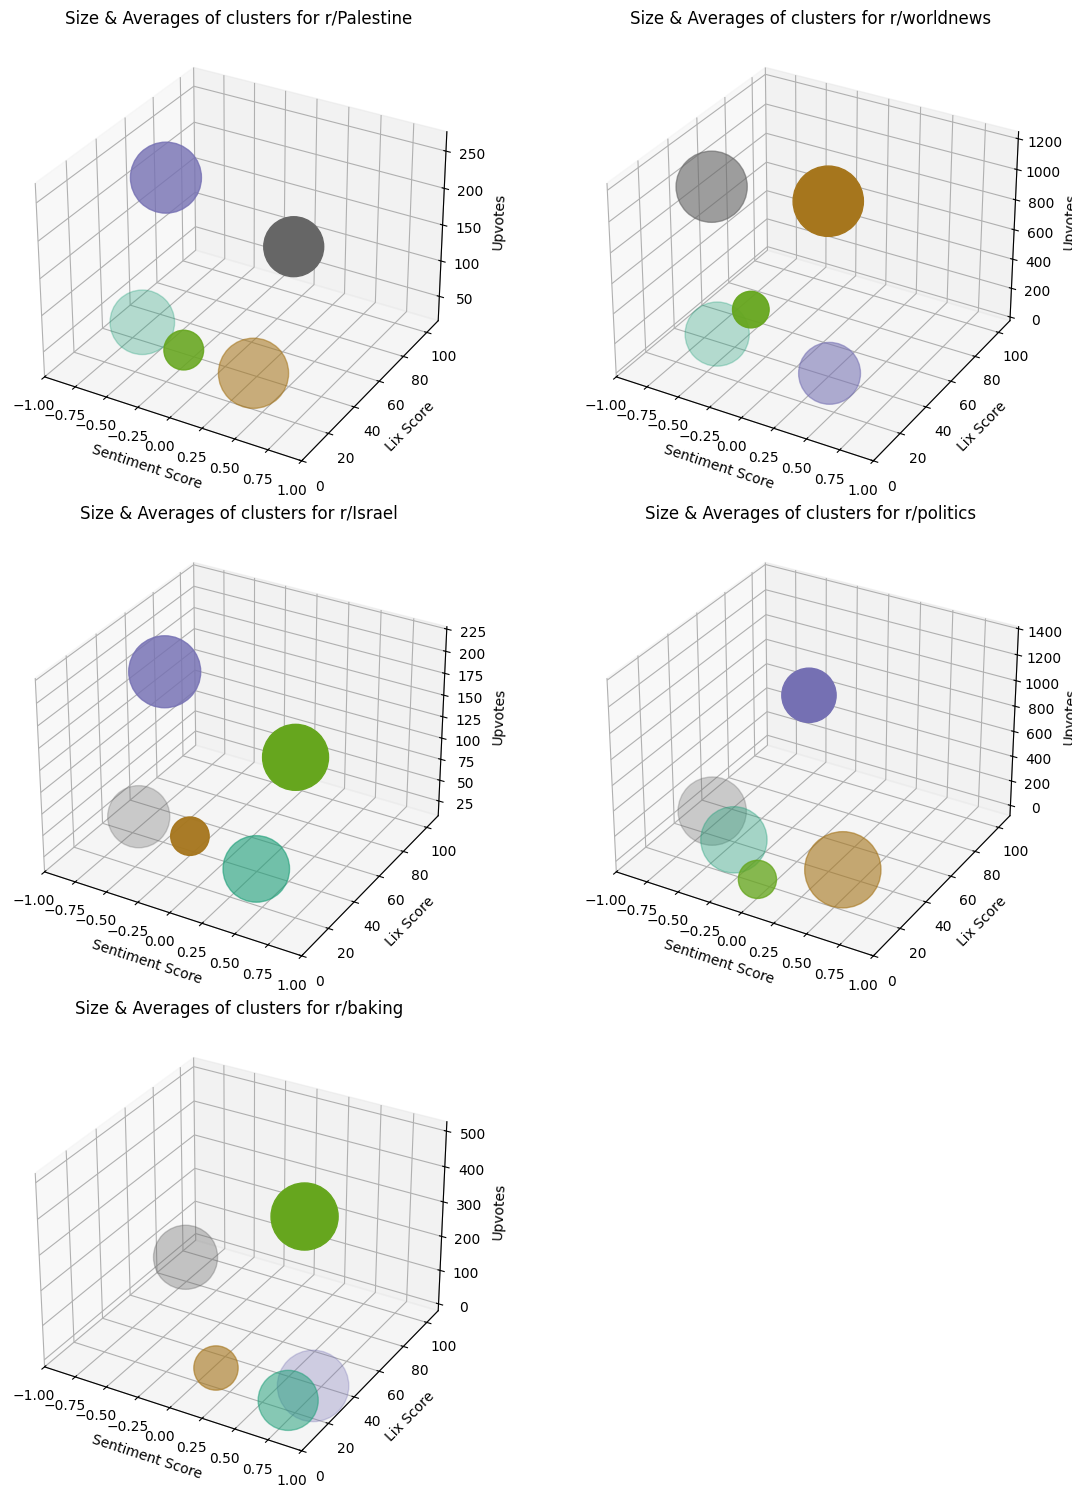

In [6]:
# Set clustering method for visualization
method = 'kmeans'
cluster_type = f'{method}_cluster'
cluster_stats = {}

for sub, df in dfs_clustered.items():
    cluster_stats[sub] = pd.DataFrame(columns=['sub', 'cluster', 'observations', 'percentage', 'avg_upvotes', 'avg_lix_score', 'avg_log_lix_score', 'avg_sentiment_score'])
    total_observations = len(df)
    for cluster in df[cluster_type].unique():
        cluster_df = df[df[cluster_type] == cluster]
        cluster_observations = len(cluster_df)
        percentage = cluster_observations / total_observations
        avg_upvotes = cluster_df['upvotes'].mean()
        avg_lix_score = cluster_df['lix_score'].mean()
        avg_log_lix_score = cluster_df['log_lix_score'].mean()
        avg_sentiment_score = cluster_df['sentiment_score'].mean()
        
        cluster_stats[sub].loc[cluster] = {
            'sub': sub,
            'cluster': cluster,
            'observations': cluster_observations,
            'percentage': percentage,
            'avg_upvotes': avg_upvotes,
            'avg_lix_score': avg_lix_score,
            'avg_log_lix_score': avg_log_lix_score,
            'avg_sentiment_score': avg_sentiment_score,
        }

# Calculate the number of rows and columns
n_cols = 2
n_subs = len(cluster_stats)
n_rows = (n_subs + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 5), subplot_kw={'projection': '3d'})
lix_lim = [0, 110]
sentiment_lim = [-1, 1]

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, (sub, df) in enumerate(cluster_stats.items()):
    n_clusters = df.shape[0]
    # Plot the 3D scatterplot
    scatter = axes[i].scatter(
        df['avg_sentiment_score'], df['avg_lix_score'], df['avg_upvotes'],
        facecolors='none', c=df['cluster'], cmap='Dark2', s=df['percentage']*100*100
    )
    axes[i].set_title(f'Size & Averages of clusters for r/{sub}')
    axes[i].set_xlabel('Sentiment Score')
    axes[i].set_ylabel('Lix Score')
    axes[i].set_zlabel('Upvotes')
    axes[i].set_ylim(lix_lim)
    axes[i].set_xlim(sentiment_lim)

# Hide any unused subplot axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [7]:
cluster_stats["Palestine"]

sub  cluster  observations  percentage  avg_upvotes  avg_lix_score  \
1  Palestine        1           771    0.261267   259.173800      35.190885   
2  Palestine        2           241    0.081667    97.970954       6.761675   
4  Palestine        4           549    0.186039   215.038251      35.634546   
0  Palestine        0           637    0.215859    45.557300      38.285881   
3  Palestine        3           753    0.255168    31.782205      34.229452   

   avg_log_lix_score  avg_sentiment_score  
1           3.496482            -0.396407  
2           1.808395             0.041312  
4           3.511554             0.569070  
0           3.583337            -0.646175  
3           3.466865             0.284296

### Regression of numerical features

LIX Regression Results:
   subreddit  R_squared  coefficient  intercept
0  Palestine   0.000455     0.001738   4.234535
1  worldnews   0.005022     0.008127   4.951223
2     Israel   0.000190    -0.001127   4.068051
3   politics   0.000544     0.002783   3.571652
4     baking   0.007055     0.012399   3.345655

Sentiment Regression Results:
   subreddit  R_squared  coefficient  intercept
0  Palestine   0.002879    -0.104918   4.286319
1  worldnews   0.001466    -0.115816   5.220658
2     Israel   0.000007    -0.005306   4.028314
3   politics   0.001106     0.093604   3.679457
4     baking   0.037783    -0.804291   4.125397

Absolute Sentiment Regression Results:
   subreddit     R_squared  coefficient  intercept
0  Palestine  7.977819e-04     0.134184   4.219857
1  worldnews  3.362983e-04     0.124096   5.175842
2     Israel  1.312286e-03    -0.176114   4.130164
3   politics  8.917146e-07    -0.006108   3.670599
4     baking  1.557640e-02    -0.946507   4.299248


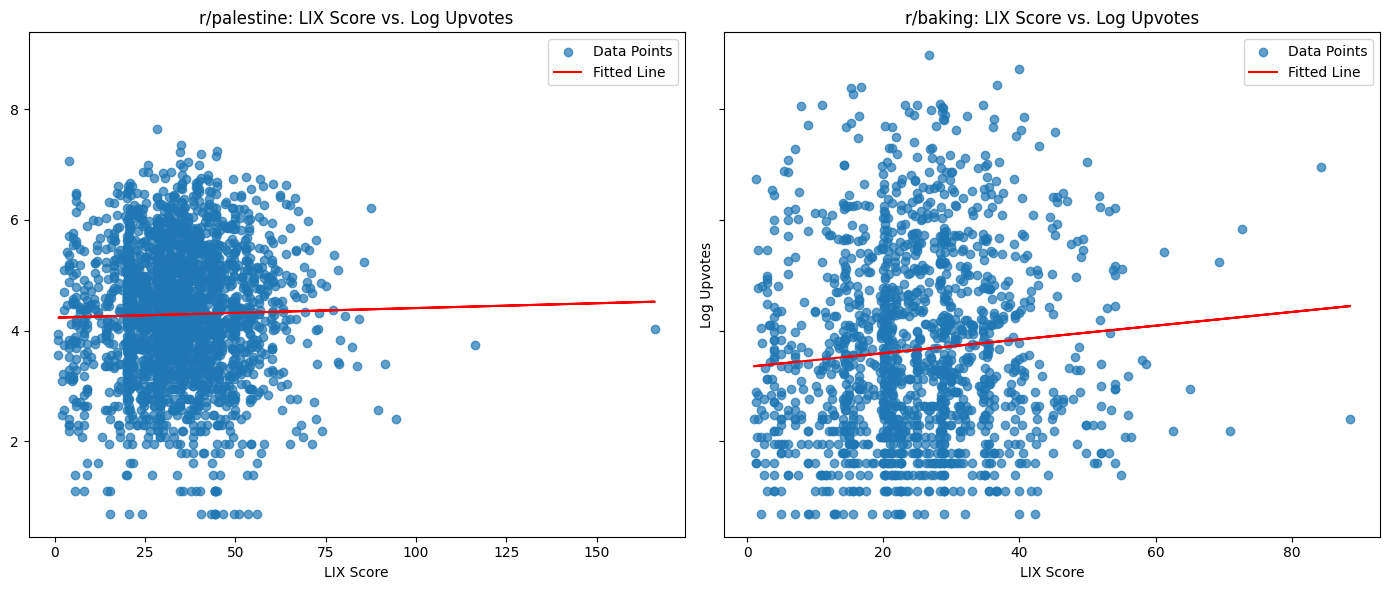

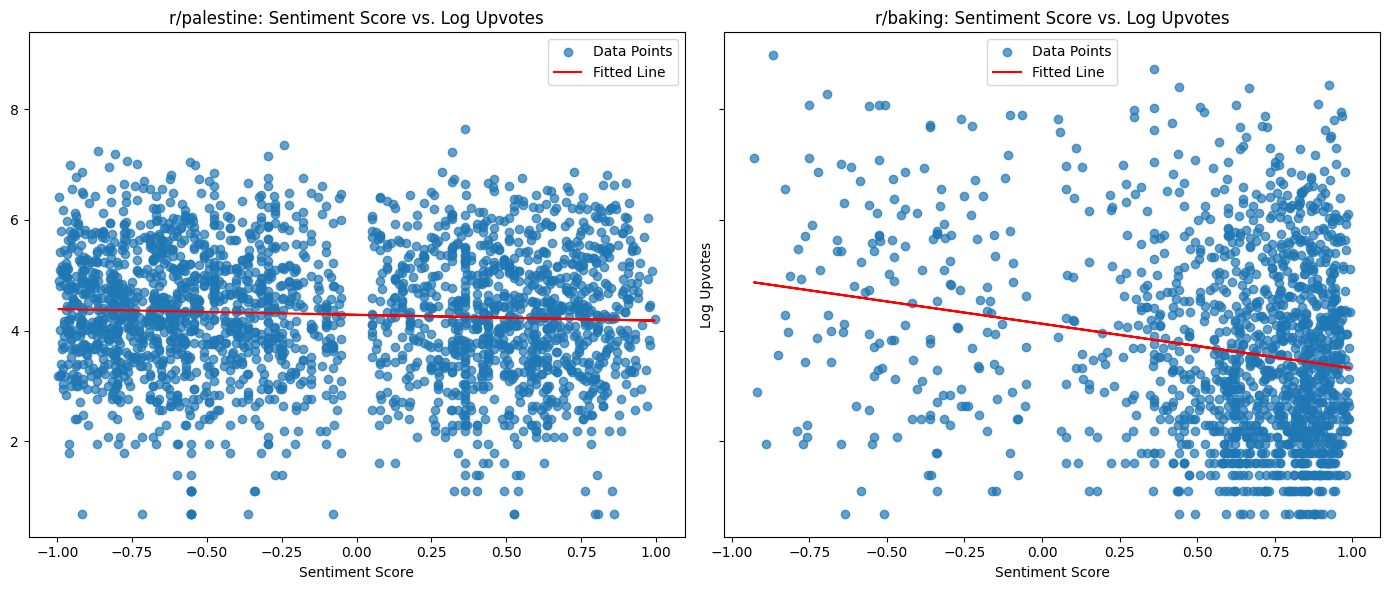

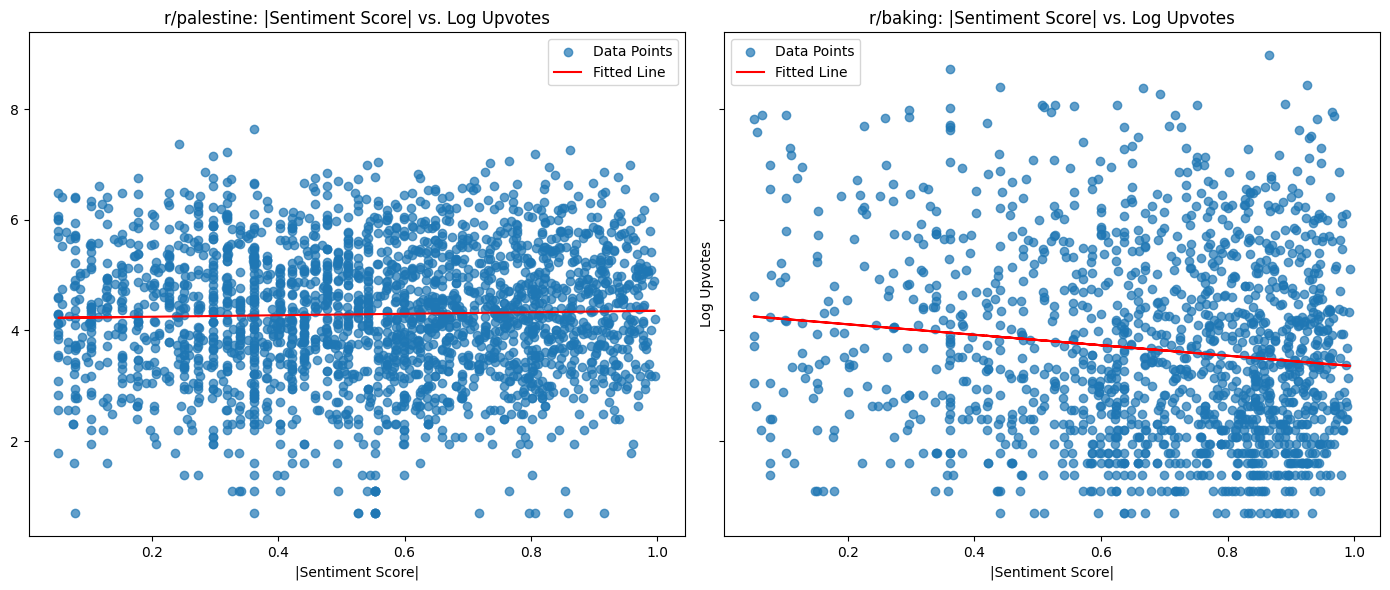

In [8]:
# Prepare results storage
lix_results = []
sentiment_results = []
absolute_sentiment_results = []

# Perform regression for each subreddit in dfs_clustered
for subreddit, df in dfs_clustered.items():
    # Ensure required columns exist in the DataFrame
    if 'lix_score' in df.columns and 'sentiment_score' in df.columns and 'log_upvotes' in df.columns:
        # Filter out sentiment values between -0.05 and 0.05
        df = df[(df['sentiment_score'] < -0.05) | (df['sentiment_score'] > 0.05)]

        # Linear regression: LIX score ~ Upvotes
        X_lix = df[['lix_score']].values.reshape(-1, 1)
        y = df['log_upvotes'].values.reshape(-1, 1)
        lix_model = LinearRegression().fit(X_lix, y)
        y_pred_lix = lix_model.predict(X_lix)

        # Store LIX results
        lix_results.append({
            'subreddit': subreddit,
            'R_squared': r2_score(y, y_pred_lix),
            'coefficient': lix_model.coef_[0][0],
            'intercept': lix_model.intercept_[0]
        })

        # Linear regression: Sentiment score ~ Upvotes
        X_sentiment = df[['sentiment_score']].values.reshape(-1, 1)
        sentiment_model = LinearRegression().fit(X_sentiment, y)
        y_pred_sentiment = sentiment_model.predict(X_sentiment)

        # Store Sentiment results
        sentiment_results.append({
            'subreddit': subreddit,
            'R_squared': r2_score(y, y_pred_sentiment),
            'coefficient': sentiment_model.coef_[0][0],
            'intercept': sentiment_model.intercept_[0]
        })

        # Linear regression: Absolute Sentiment ~ Upvotes
        X_absolute_sentiment = df[['sentiment_score']].abs().values.reshape(-1, 1)
        absolute_sentiment_model = LinearRegression().fit(X_absolute_sentiment, y)
        y_pred_absolute_sentiment = absolute_sentiment_model.predict(X_absolute_sentiment)

        # Store Absolute Sentiment results
        absolute_sentiment_results.append({
            'subreddit': subreddit,
            'R_squared': r2_score(y, y_pred_absolute_sentiment),
            'coefficient': absolute_sentiment_model.coef_[0][0],
            'intercept': absolute_sentiment_model.intercept_[0]
        })

# Convert results to DataFrames
lix_results_df = pd.DataFrame(lix_results)
sentiment_results_df = pd.DataFrame(sentiment_results)
absolute_sentiment_results_df = pd.DataFrame(absolute_sentiment_results)

# Display results
print("LIX Regression Results:")
print(lix_results_df)
print("\nSentiment Regression Results:")
print(sentiment_results_df)
print("\nAbsolute Sentiment Regression Results:")
print(absolute_sentiment_results_df)

# Plot regression results for r/baking and r/palestine if available
if 'baking' in dfs_clustered and 'Palestine' in dfs_clustered:
    df_baking = dfs_clustered['baking']
    df_palestine = dfs_clustered['Palestine']

    # Filter sentiment values between -0.05 and 0.05
    df_baking = df_baking[(df_baking['sentiment_score'] < -0.05) | (df_baking['sentiment_score'] > 0.05)]
    df_palestine = df_palestine[(df_palestine['sentiment_score'] < -0.05) | (df_palestine['sentiment_score'] > 0.05)]

    # Measures to plot
    measures = ['lix_score', 'sentiment_score', 'absolute_sentiment']
    titles = ['LIX Score', 'Sentiment Score', '|Sentiment Score|']
    for i, measure in enumerate(measures):
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

        # Palestine Plot
        if measure == 'absolute_sentiment':
            X_palestine = df_palestine[['sentiment_score']].abs().values.reshape(-1, 1)
        else:
            X_palestine = df_palestine[[measure]].values.reshape(-1, 1)
        y_palestine = df_palestine['log_upvotes'].values.reshape(-1, 1)
        palestine_model = LinearRegression().fit(X_palestine, y_palestine)
        y_palestine_pred = palestine_model.predict(X_palestine)
        axes[0].scatter(X_palestine, y_palestine, alpha=0.7, label='Data Points')
        axes[0].plot(X_palestine, y_palestine_pred, color='red', label='Fitted Line')
        axes[0].set_title(f'r/palestine: {titles[i]} vs. Log Upvotes')
        axes[0].set_xlabel(titles[i])
        axes[0].legend()

        # Baking Plot
        if measure == 'absolute_sentiment':
            X_baking = df_baking[['sentiment_score']].abs().values.reshape(-1, 1)
        else:
            X_baking = df_baking[[measure]].values.reshape(-1, 1)
        y_baking = df_baking['log_upvotes'].values.reshape(-1, 1)
        baking_model = LinearRegression().fit(X_baking, y_baking)
        y_baking_pred = baking_model.predict(X_baking)
        axes[1].scatter(X_baking, y_baking, alpha=0.7, label='Data Points')
        axes[1].plot(X_baking, y_baking_pred, color='red', label='Fitted Line')
        axes[1].set_title(f'r/baking: {titles[i]} vs. Log Upvotes')
        axes[1].set_xlabel(titles[i])
        axes[1].set_ylabel('Log Upvotes')
        axes[1].legend()

        plt.tight_layout()
        plt.show()


### Divisiveness and similarity

   subreddit  divisiveness
0  Palestine      0.221889
1  worldnews      0.236893
2     Israel      0.221465
3   politics      0.224949
4     baking      0.000000
0   -0.058315
1   -0.151893
2   -0.041182
3    0.067565
4    0.415984
Name: weighted_avg_sentiment, dtype: float64
0    3.404538
1    3.465331
2    3.405848
3    3.417003
4    3.145600
Name: weighted_avg_log_lix, dtype: float64


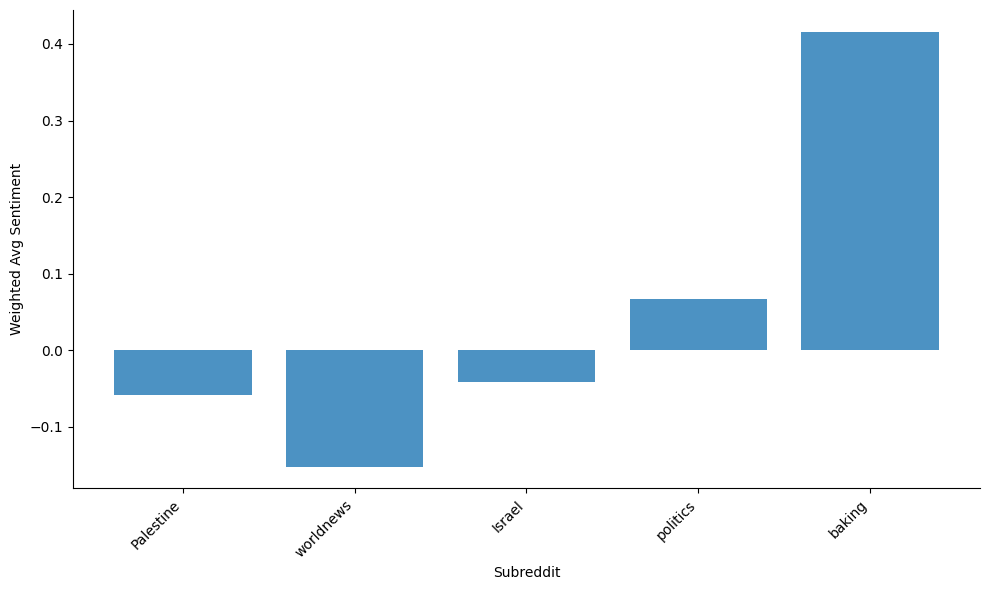

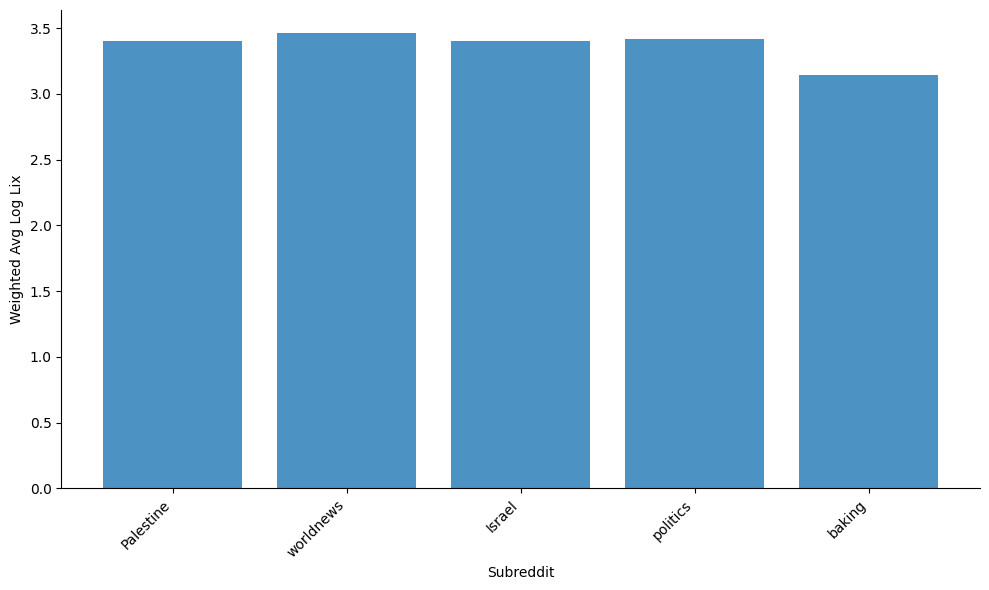

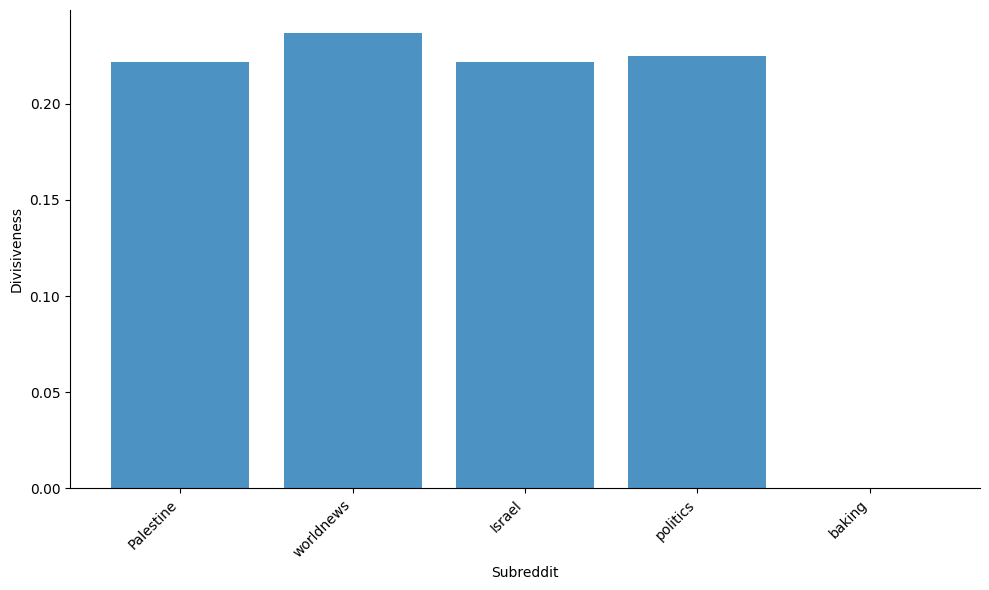

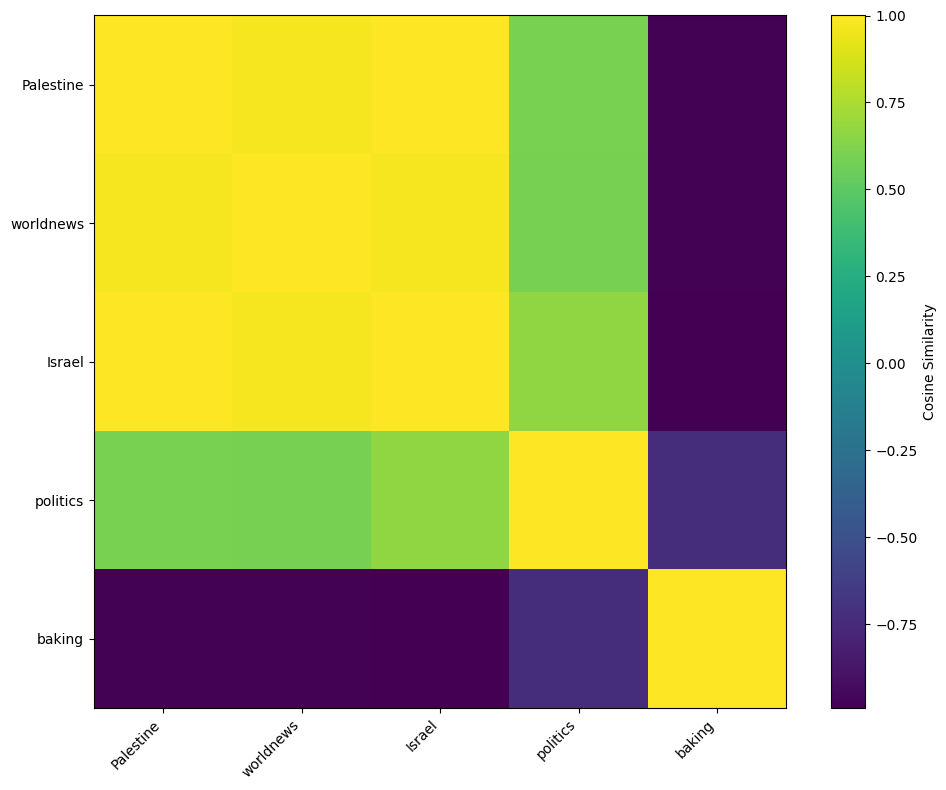

In [9]:
# Function to compute weighted averages with correct proportional weights
def compute_weighted_average(df, value_col, weight_col1, weight_col2):
    # Compute the weights as weight_col1 * weight_col2
    weights = df[weight_col1] * df[weight_col2]
    # Normalize weights to proportions
    weights /= weights.sum()
    # Compute the weighted average
    return (df[value_col] * weights).sum()

# Hybrid function to compute divisiveness
def compute_hybrid_divisiveness(df, value_col='sentiment_score', skewness_threshold=1.5):
    # Exclude neutral sentiments (-0.05 to 0.05)
    filtered = df.loc[(df[value_col] < -0.05) | (df[value_col] > 0.05)]
    if filtered.empty or len(filtered) < 3:
        return 0

    # Use the filtered sentiment scores directly
    values = filtered[value_col].values

    # Compute skewness and kurtosis
    g = skew(values)  # Skewness
    k = kurtosis(values, fisher=False)  # Kurtosis
    n = len(values)

    # Detect peaks in histogram
    hist, bin_edges = np.histogram(values, bins=30, density=True)
    peaks, _ = find_peaks(hist, prominence=0.05)

    # If skewness is too high or only one peak, classify as unimodal
    if abs(g) > skewness_threshold or len(peaks) <= 1:
        return 0

    # Otherwise, calculate Bimodality Coefficient
    bc = (g**2 + 1) / (k + (3 * ((n - 1)**2) / ((n - 2) * (n - 3))))
    return bc

# Initialize lists to store subreddit-level stats
subreddit_stats = []

# Calculate weighted averages for sentiment and LIX using cluster_stats
for subreddit, df in cluster_stats.items():
    weighted_avg_sentiment = compute_weighted_average(df, 'avg_sentiment_score', 'avg_upvotes', 'observations')
    weighted_avg_log_lix = compute_weighted_average(df, 'avg_log_lix_score', 'avg_upvotes', 'observations')

    # Store results for LIX and sentiment
    subreddit_stats.append({
        'subreddit': subreddit,
        'weighted_avg_sentiment': weighted_avg_sentiment,
        'weighted_avg_log_lix': weighted_avg_log_lix,
    })

# Convert subreddit_stats to a DataFrame
subreddit_df = pd.DataFrame(subreddit_stats)

# Add divisiveness from dfs_clustered using the hybrid BC
divisiveness_stats = []

for subreddit, df in dfs_clustered.items():
    # Compute divisiveness using the hybrid approach
    divisiveness = compute_hybrid_divisiveness(df)
    divisiveness_stats.append({'subreddit': subreddit, 'divisiveness': divisiveness})

# Convert divisiveness stats to a DataFrame
divisiveness_df = pd.DataFrame(divisiveness_stats)
print(divisiveness_df)

# Merge LIX and sentiment with divisiveness
subreddit_df = subreddit_df.merge(divisiveness_df, on='subreddit')
print(subreddit_df["weighted_avg_sentiment"])
print(subreddit_df["weighted_avg_log_lix"])

# Bar Charts: Non-Normalized Weighted Averages and Divisiveness
attributes = ['weighted_avg_sentiment', 'weighted_avg_log_lix', 'divisiveness']
for attribute in attributes:
    plt.figure(figsize=(10, 6))
    plt.bar(subreddit_df['subreddit'], subreddit_df[attribute], alpha=0.8)
    plt.ylabel(attribute.replace("_", " ").title())  # Use attribute name as y-axis label
    plt.xlabel('Subreddit')  # Label for the x-axis
    plt.xticks(rotation=45, ha='right')
    plt.gca().spines['top'].set_visible(False)  # Remove top spine
    plt.gca().spines['right'].set_visible(False)  # Remove right spine
    plt.tight_layout()
    plt.show()

# Normalize the features for similarity calculation
features_to_normalize = ['weighted_avg_sentiment', 'weighted_avg_log_lix', 'divisiveness']
scaler = StandardScaler()
subreddit_df[features_to_normalize] = scaler.fit_transform(subreddit_df[features_to_normalize])

# Compute pairwise cosine similarity
similarity_matrix = cosine_similarity(subreddit_df[features_to_normalize])

# Convert similarity matrix to a DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=subreddit_df['subreddit'], columns=subreddit_df['subreddit'])

# Plot a heatmap of the similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(similarity_df, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.xticks(range(len(similarity_df)), similarity_df.columns, rotation=45, ha='right')
plt.yticks(range(len(similarity_df)), similarity_df.index)
plt.tight_layout()
plt.savefig("Cosine_Similarity.png", dpi = 300)
plt.show()


### Divisiveness and similarity (without baking)

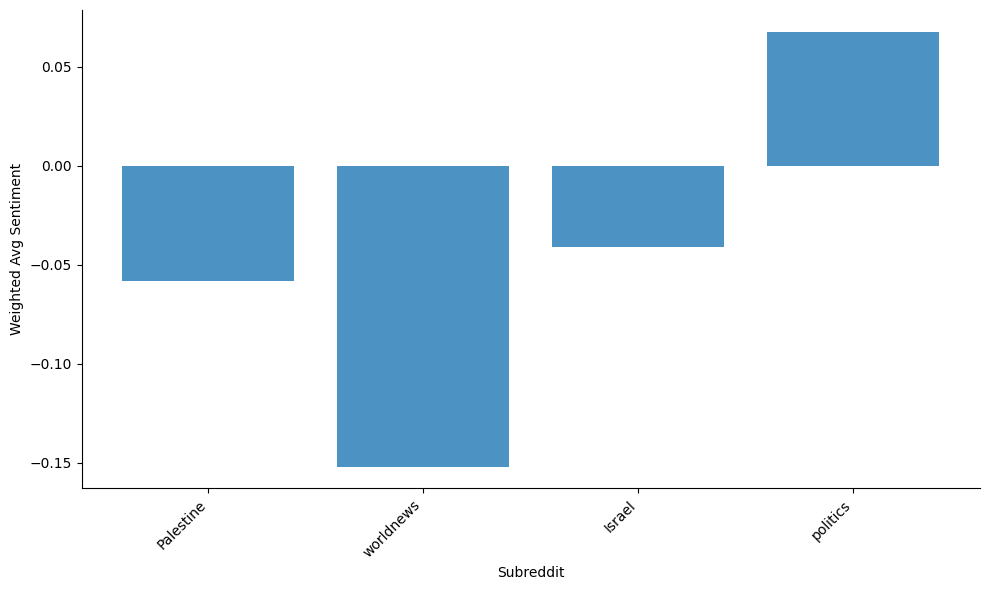

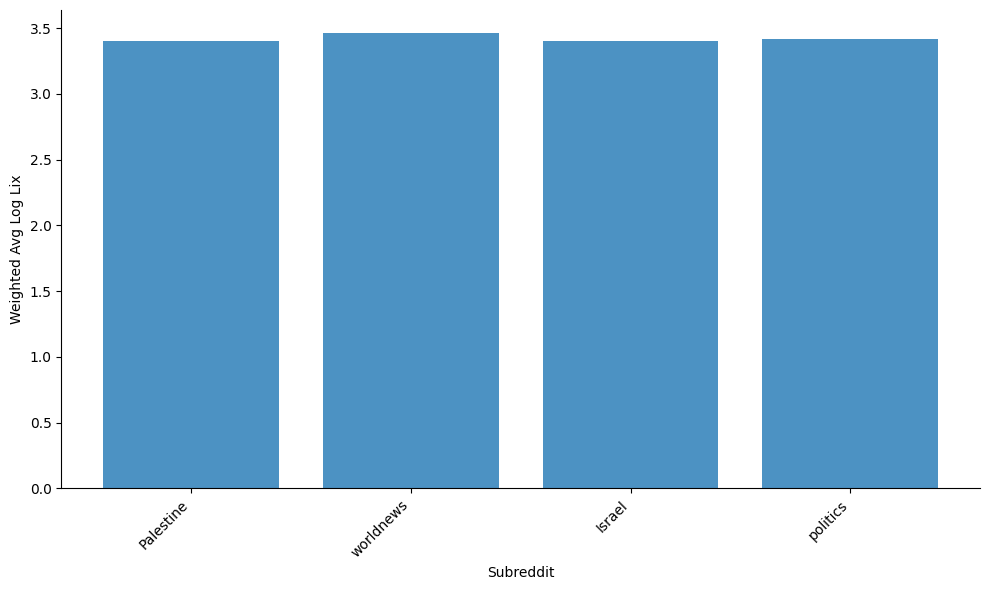

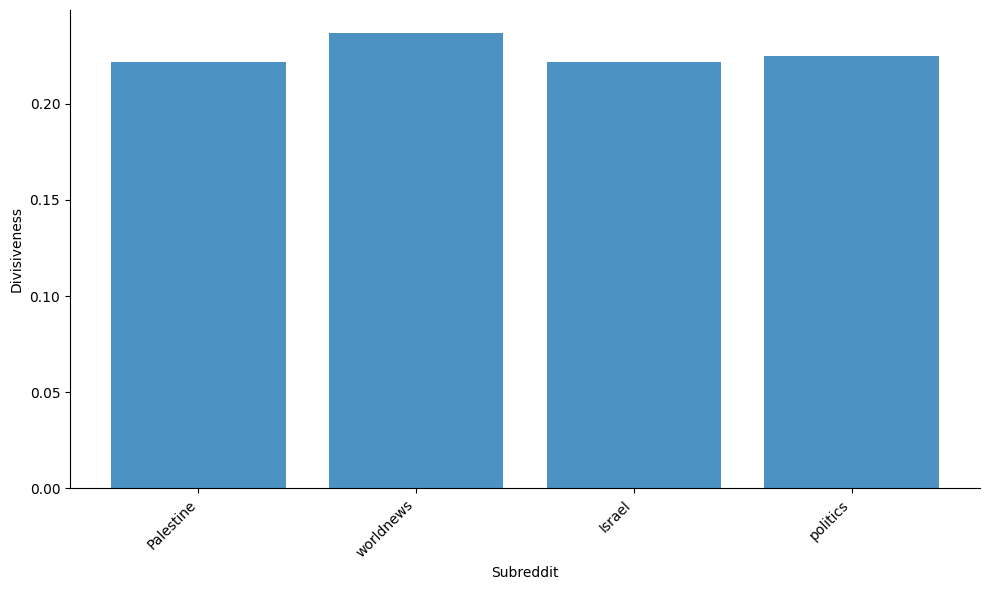

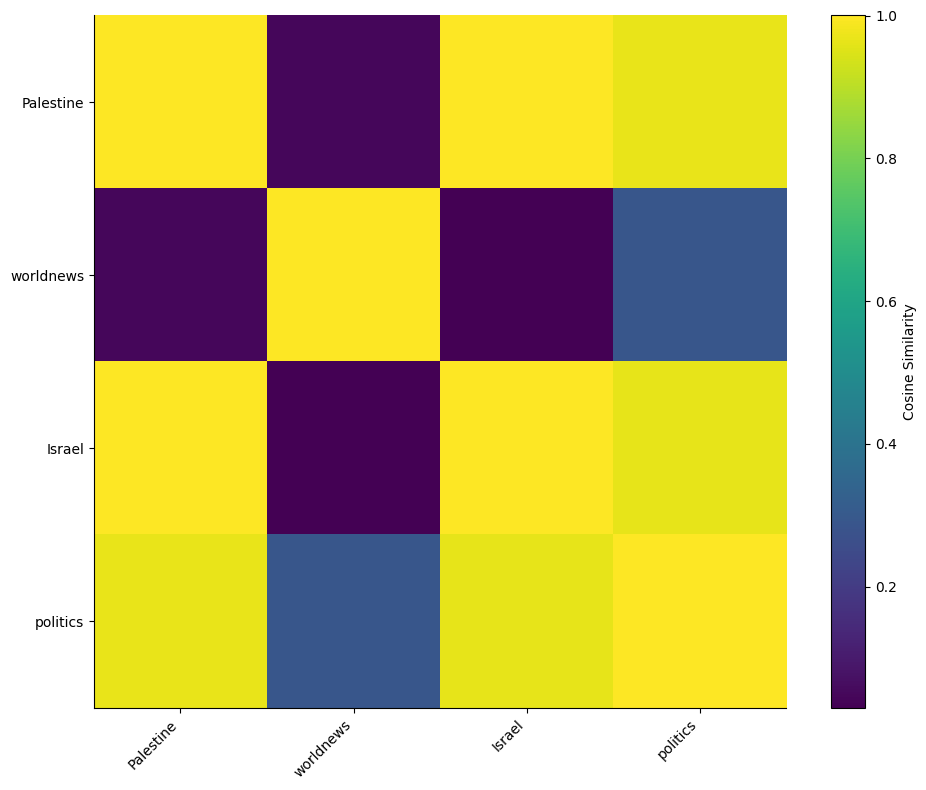

In [10]:
# Initialize lists to store subreddit-level stats
subreddit_stats = []

# Calculate weighted averages for sentiment and log LIX using cluster_stats, excluding `baking`
for subreddit, df in cluster_stats.items():
    if subreddit == 'baking':
        continue  # Skip baking
    weighted_avg_sentiment = compute_weighted_average(df, 'avg_sentiment_score', 'avg_upvotes', 'observations')
    weighted_avg_log_lix = compute_weighted_average(df, 'avg_log_lix_score', 'avg_upvotes', 'observations')

    # Store results for sentiment and log LIX
    subreddit_stats.append({
        'subreddit': subreddit,
        'weighted_avg_sentiment': weighted_avg_sentiment,
        'weighted_avg_log_lix': weighted_avg_log_lix,
    })

# Convert subreddit_stats to a DataFrame
subreddit_df = pd.DataFrame(subreddit_stats)

# Add divisiveness from dfs_clustered using the hybrid BC, excluding `baking`
divisiveness_stats = []

for subreddit, df in dfs_clustered.items():
    if subreddit == 'baking':
        continue  # Skip baking
    # Compute divisiveness using the hybrid approach
    divisiveness = compute_hybrid_divisiveness(df)
    divisiveness_stats.append({'subreddit': subreddit, 'divisiveness': divisiveness})

# Convert divisiveness stats to a DataFrame
divisiveness_df = pd.DataFrame(divisiveness_stats)

# Merge sentiment, log LIX, and divisiveness
subreddit_df = subreddit_df.merge(divisiveness_df, on='subreddit')

# Bar Charts: Non-Normalized Weighted Sentiment, Log LIX, and Divisiveness
attributes = ['weighted_avg_sentiment', 'weighted_avg_log_lix', 'divisiveness']
for attribute in attributes:
    plt.figure(figsize=(10, 6))
    plt.bar(subreddit_df['subreddit'], subreddit_df[attribute], alpha=0.8)
    plt.ylabel(attribute.replace("_", " ").title())  # Use attribute name as y-axis label
    plt.xlabel('Subreddit')  # Label for the x-axis
    plt.xticks(rotation=45, ha='right')
    plt.gca().spines['top'].set_visible(False)  # Remove top spine
    plt.gca().spines['right'].set_visible(False)  # Remove right spine
    plt.tight_layout()
    plt.show()

# Normalize sentiment, log LIX, and divisiveness for similarity calculation
features_to_normalize = ['weighted_avg_sentiment', 'weighted_avg_log_lix', 'divisiveness']
scaler = MinMaxScaler()
subreddit_df[features_to_normalize] = scaler.fit_transform(subreddit_df[features_to_normalize])

# Compute pairwise cosine similarity
similarity_matrix = cosine_similarity(subreddit_df[features_to_normalize])

# Convert similarity matrix to a DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=subreddit_df['subreddit'], columns=subreddit_df['subreddit'])

# Plot a heatmap of the similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(similarity_df, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.xticks(range(len(similarity_df)), similarity_df.columns, rotation=45, ha='right')
plt.yticks(range(len(similarity_df)), similarity_df.index)
plt.gca().spines['top'].set_visible(False)  # Remove top spine
plt.gca().spines['right'].set_visible(False)  # Remove right spine
plt.tight_layout()
plt.show()


# Euclidian distance

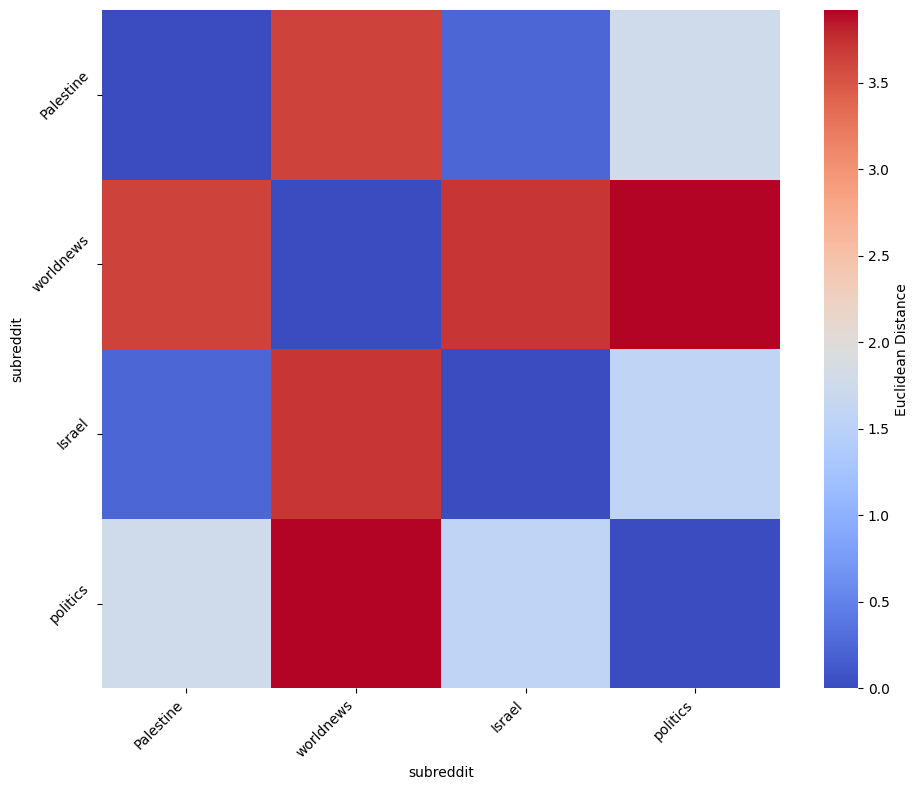

In [11]:
# Normalize the features
features_to_normalize = ['weighted_avg_sentiment', 'divisiveness',"weighted_avg_log_lix"]
scaler = StandardScaler()
subreddit_df[features_to_normalize] = scaler.fit_transform(subreddit_df[features_to_normalize])

# Compute Euclidean distance matrix
distance_matrix = squareform(pdist(subreddit_df[features_to_normalize], metric='euclidean'))

# Convert distance matrix to a DataFrame
distance_df = pd.DataFrame(distance_matrix, index=subreddit_df['subreddit'], columns=subreddit_df['subreddit'])

# Plot a heatmap of the Euclidean distances
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, cmap='coolwarm', annot=False, square=True, cbar_kws={'label': 'Euclidean Distance'})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
